# Innovation Degree of Freedom
       This file calculates the degree of freedom of innovation (defined as Num(immediate potential objects can be made) - Num(objs already made)) at different time points in the family history
   
   Created by Grace Deng in August, 2020. Modified in December, 2020

In [1]:
%matplotlib inline

import os, re, glob, datetime, json
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns

### Load empowerment dictionary
    Defined as the number of immediate objects that could be made from an item

In [2]:
with open('../../3_technology/tech_tree/products.txt') as json_file:
    emp = json.load(json_file)

In [3]:
emp = {int(k): v for k, v in emp.items() if len(v)!= 0}

### Load map change data

In [421]:
#this csv might be outdated and
data = pd.read_csv('../../2_demographics/outputs/parsed_map_change.csv', index_col = [0])

In [310]:
data = data.sort_values(by = 'time')

In [311]:
data.head(n=10)

,time,locX,locY,obj,playerID,family
0,122.31,-5137,-1395,0,2276905,time-1573895755_eve-2276905_name-ZABICKI
1,125.06,-5138,-1394,0,2276905,time-1573895755_eve-2276905_name-ZABICKI
2,127.21,-5138,-1395,236,2276905,time-1573895755_eve-2276905_name-ZABICKI
3,129.09,-5135,-1396,134,2276905,time-1573895755_eve-2276905_name-ZABICKI
4,130.33,-5136,-1395,0,2276905,time-1573895755_eve-2276905_name-ZABICKI
5,147.25,-5136,-1386,0,2276905,time-1573895755_eve-2276905_name-ZABICKI
6,149.37,-5138,-1386,0,2276905,time-1573895755_eve-2276905_name-ZABICKI
7,151.23,-5137,-1386,0,2276905,time-1573895755_eve-2276905_name-ZABICKI
8,172.11,-5125,-1393,2873,2276905,time-1573895755_eve-2276905_name-ZABICKI
9,175.11,-5123,-1392,2742,2276905,time-1573895755_eve-2276905_name-ZABICKI


How many data points?

In [312]:
len(data)

840408

How many families?

In [341]:
fams = data.family.unique()
len(fams)

48

### Create a nested dictionary of family:{time, objects, df}

In [316]:
mydict = defaultdict(list)
for f in tqdm(fams): #loop through each family
    fam_data = data.loc[data.family == f]
    prev_techdf = [] #initialize technology degree of freedom
    prev_objs = [] #initialize cumulative objecvts
    for i,row in fam_data.iterrows(): #loop through each row in the dataframe
        fam = row['family']
        time = row['time']
        obj = row['obj']
        cum_objs = list(set(np.append(prev_objs,obj))) #append the new object to cumulative objects if it's not already in
        
        if len(cum_objs) > len(prev_objs): #only update the dictionary when a new item is discovered
            if obj in emp.keys(): 
                add_techdf = [i for i in emp[obj] if i not in cum_objs] #make sure none of the already-exist objcects is in the df
                new_techdf = list(set(np.append(prev_techdf, add_techdf)))#calculate the df brought by this new object and add it to the previous df
            else:
                new_techdf = prev_techdf
            if obj in new_techdf: #remove the new object from df if possible
                new_techdf.remove(obj)

            prev_techdf = new_techdf
            prev_objs = cum_objs
            mydict[fam].append({'time':time, 'tech_df':len(new_techdf), 'cum_objs':len(cum_objs), 'new_obj':obj})


A Jupyter Widget

### Plot

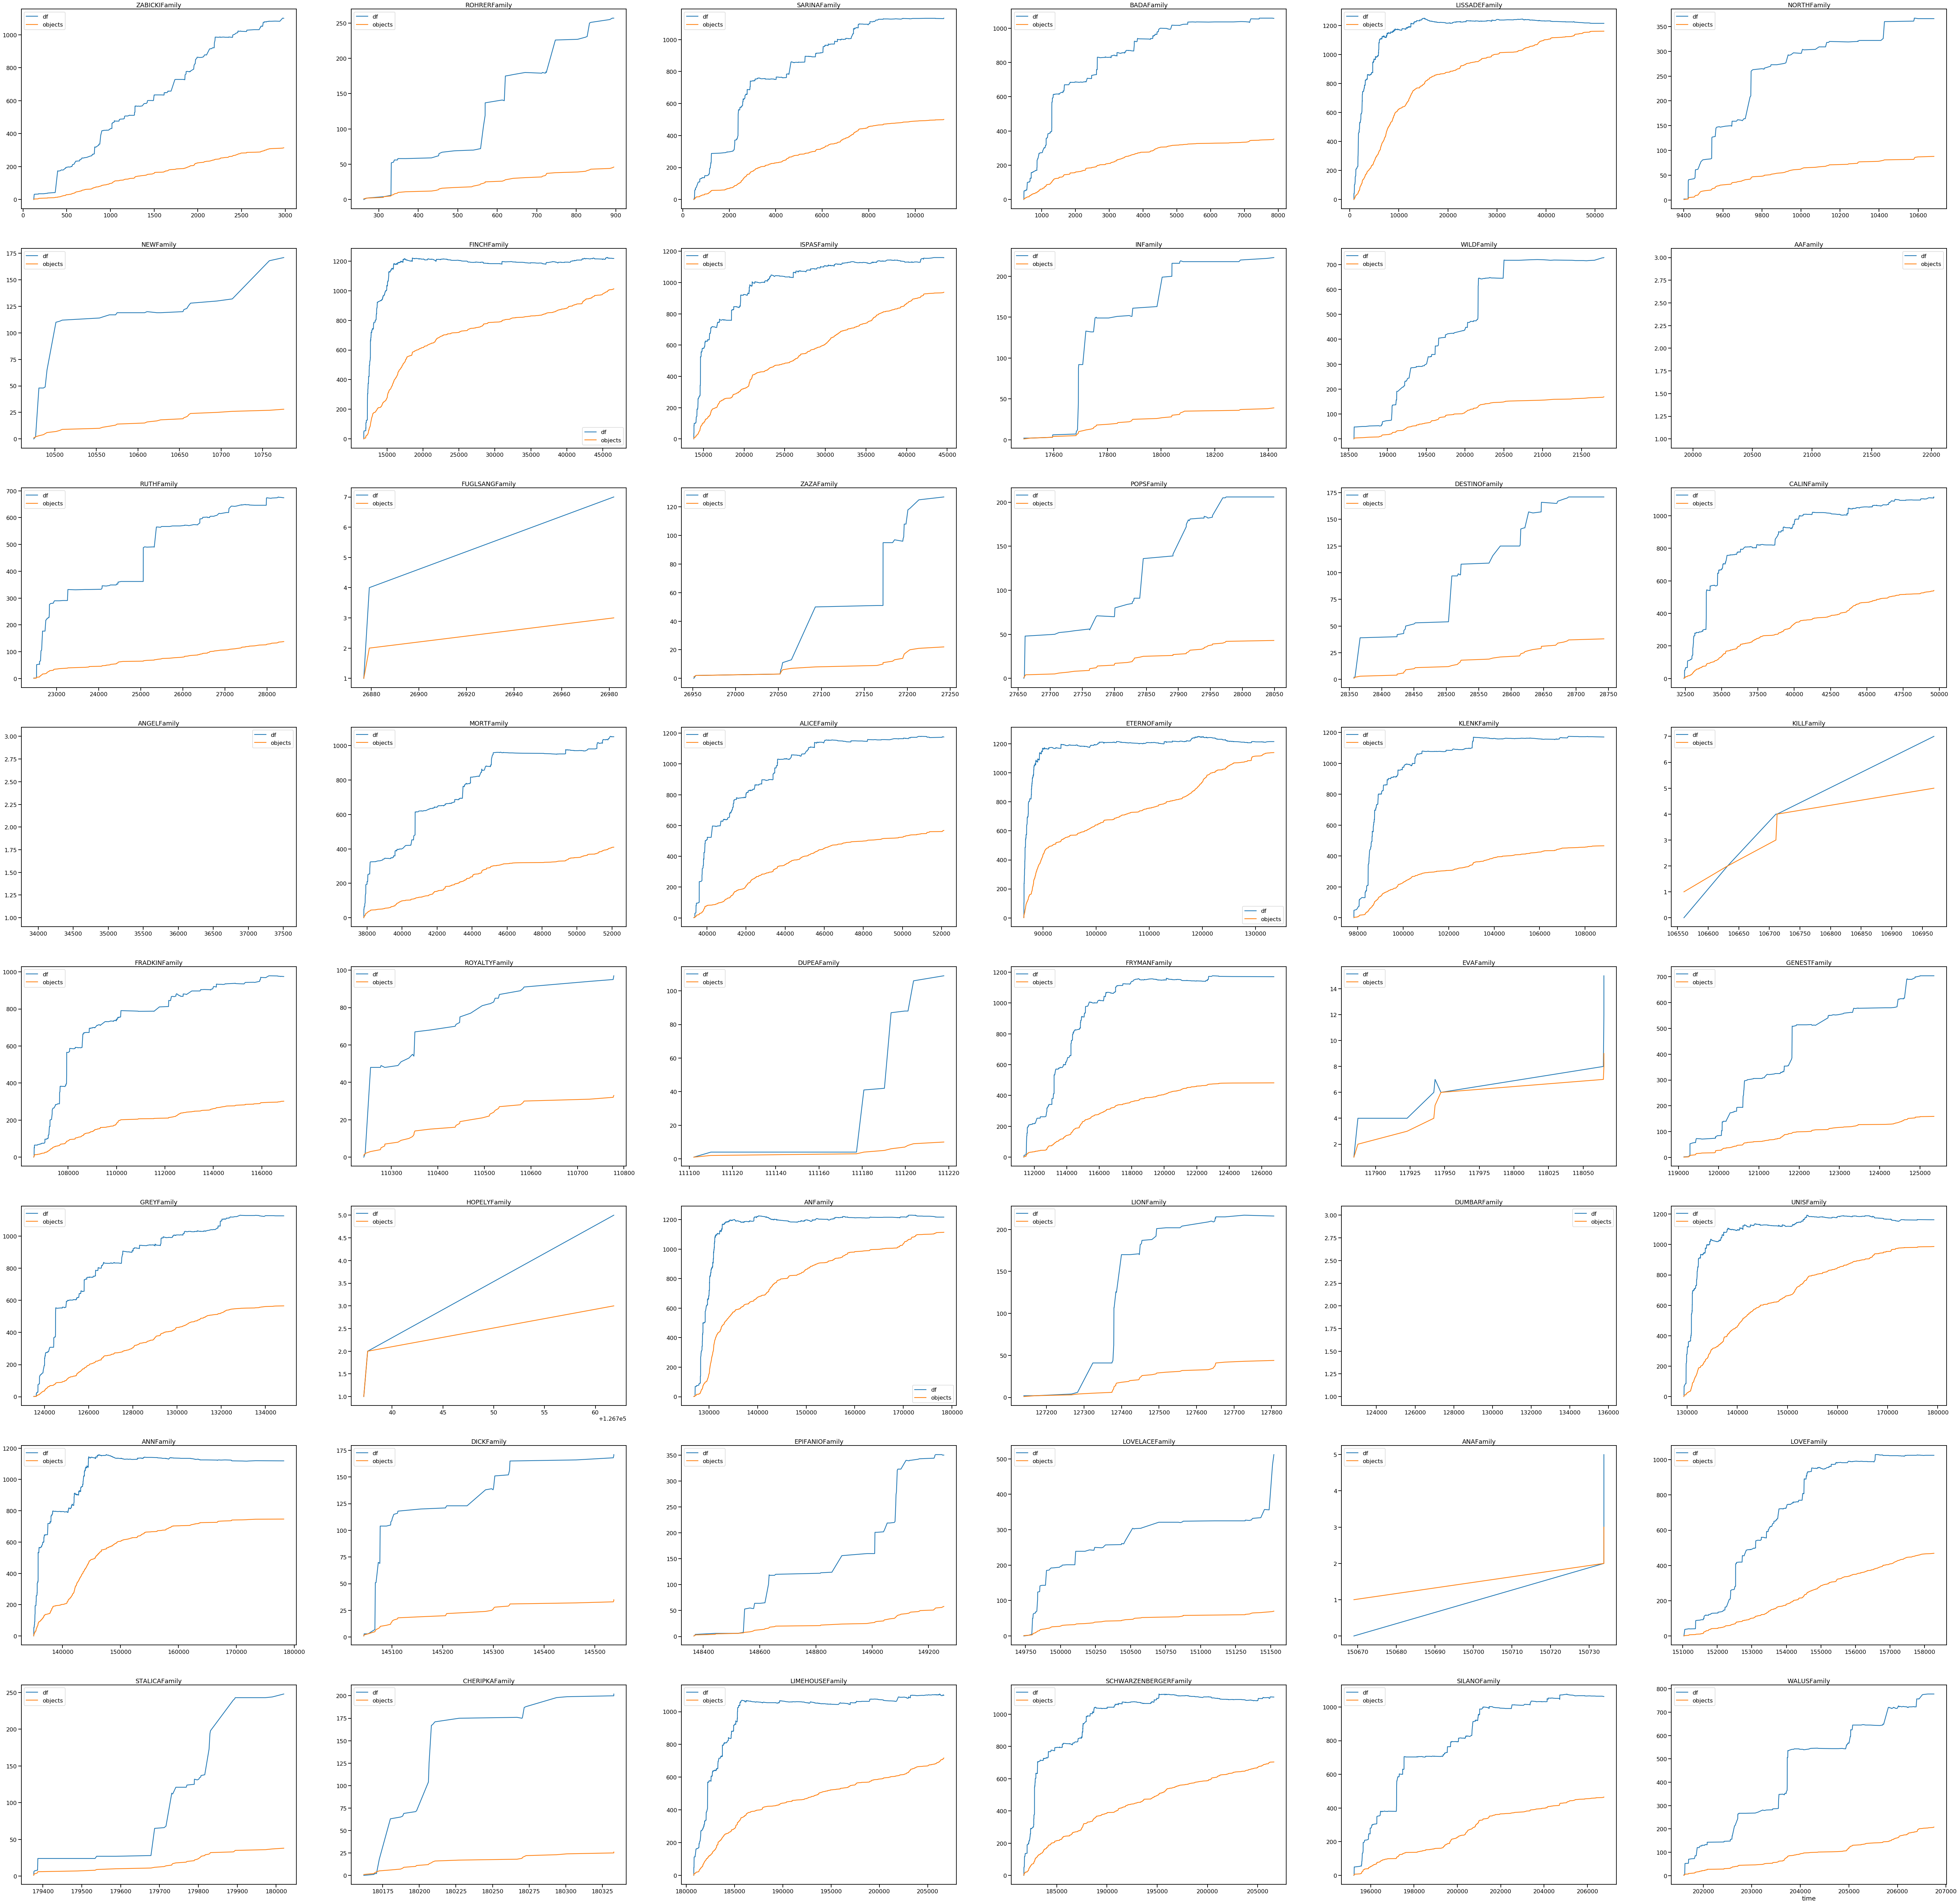

In [338]:
fig, axes = plt.subplots(8,6, figsize = (100,100))
axes = axes.flatten()
for f in range(len(fams)):
    fam_dict = mydict[fams[f]]
    all_emp = [fam_dict[i]['tech_df'] for i in range(len(fam_dict))]
    all_objs = [fam_dict[i]['cum_objs'] for i in range(len(fam_dict))]
    time = [fam_dict[i]['time'] for i in range(len(fam_dict))]

    axes[f].plot(time, all_emp, label = 'df')
    axes[f].plot(time, all_objs, label = 'objects')
    axes[f].legend()
    plt.xlabel('time')
    axes[f].set_title(fams[f].split('-')[-1] + ' Family')

In [308]:
mydict

defaultdict(list,
            {'time-1573895755_eve-2276905_name-ZABICKI': [{'cum_objs': 1,
               'emp': 0,
               'time': 122.30999994277954},
              {'cum_objs': 1, 'emp': 0, 'time': 125.05999994277954},
              {'cum_objs': 2, 'emp': 29, 'time': 127.21000003814696},
              {'cum_objs': 3, 'emp': 32, 'time': 129.08999991416928},
              {'cum_objs': 3, 'emp': 32, 'time': 130.32999992370605},
              {'cum_objs': 3, 'emp': 32, 'time': 147.25},
              {'cum_objs': 3, 'emp': 32, 'time': 149.3699998855591},
              {'cum_objs': 3, 'emp': 32, 'time': 151.23000001907351},
              {'cum_objs': 4, 'emp': 33, 'time': 172.10999989509583},
              {'cum_objs': 5, 'emp': 33, 'time': 175.10999989509583},
              {'cum_objs': 5, 'emp': 33, 'time': 176.75999999046326},
              {'cum_objs': 6, 'emp': 35, 'time': 177.53999996185303},
              {'cum_objs': 6, 'emp': 35, 'time': 178.88000011444092},
             

## Another way of calculating df
    How many more objects could be made from what the family already has?

In [361]:
recipies = pd.read_csv('../../3_technology/tech_tree/adj.csv')
recipies.head()

,ingredient1,ingredient2,product
0,706,707,717
1,706,703,718
2,100,0,96
3,2174,4349,2175
4,1323,4348,1328


In [362]:
recipies = recipies.set_index('product').T.to_dict('list')

In [414]:
d = defaultdict(list)
for f in tqdm(fams): #loop through each family
    fam_data = data.loc[data.family == f]
    prev_techdf = [] #initialize technology degree of freedom
    prev_objs = [] #initialize cumulative objecvts
    for i,row in fam_data.iterrows(): #loop through each row in the dataframe
        fam = row['family']
        time = row['time']
        obj = row['obj']
        cum_objs = list(set(np.append(prev_objs,obj))) #append the new object to cumulative objects if it's not already in
        
        if len(cum_objs) > len(prev_objs): #only update the dictionary when a new item is discovered
            if obj in emp.keys():
                add_techdf = []
                possible_techdf = [i for i in emp[obj] if i not in cum_objs] #make sure none of the already-exist objcects is in the df
                for item in possible_techdf:
                    other_ingredient = [k for k in recipies[item] if k != obj]
                    if len(other_ingredient) and other_ingredient[0] in cum_objs:
                        add_techdf = np.append(add_techdf, item)
                    
                new_techdf = list(set(np.append(prev_techdf, add_techdf)))#calculate the df brought by this new object and add it to the previous df
            else:
                new_techdf = prev_techdf
            if obj in new_techdf: #remove the new object from df if possible
                new_techdf.remove(obj)
            
            prev_techdf = new_techdf
            prev_objs = cum_objs
            d[fam].append({'time':time, 'tech_df':len(new_techdf), 'cum_objs':len(cum_objs), 'new_obj':obj})


A Jupyter Widget

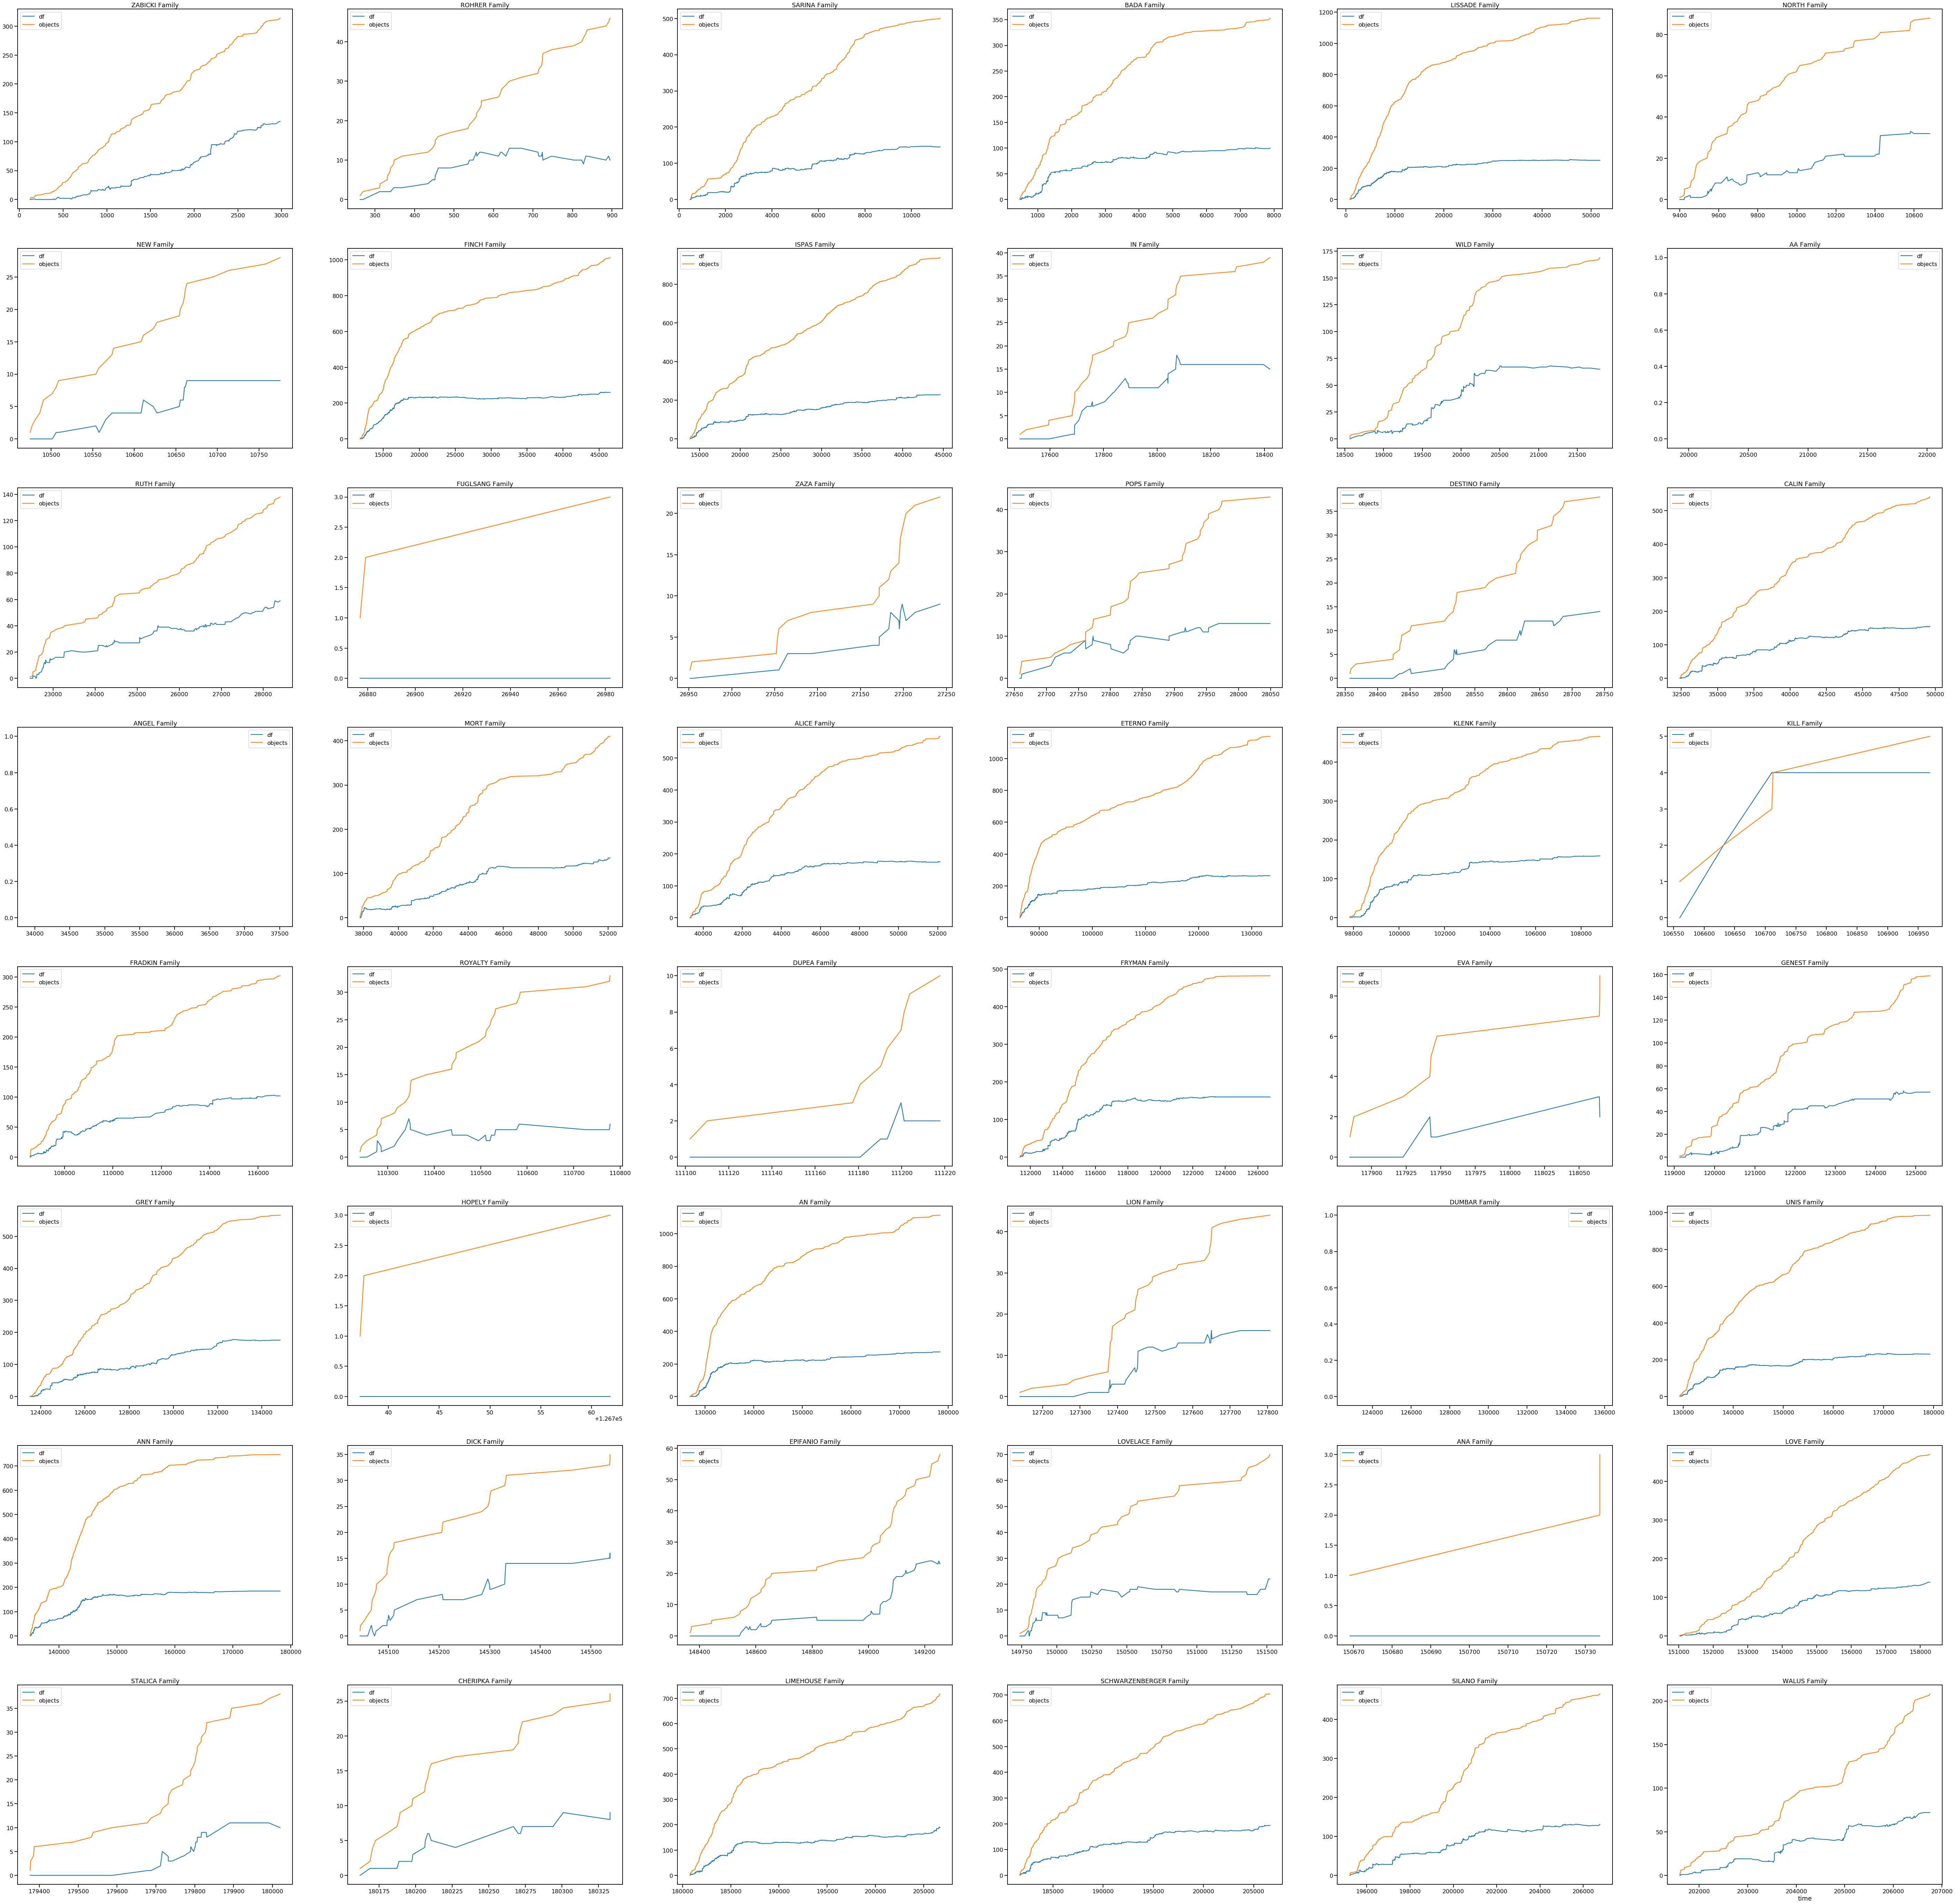

In [420]:
fig, axes = plt.subplots(8,6, figsize = (100,100))
axes = axes.flatten()
for f in range(len(fams)):
    fam_dict = d[fams[f]]
    all_emp = [fam_dict[i]['tech_df'] for i in range(len(fam_dict))]
    all_objs = [fam_dict[i]['cum_objs'] for i in range(len(fam_dict))]
    time = [fam_dict[i]['time'] for i in range(len(fam_dict))]

    axes[f].plot(time, all_emp, label = 'df')
    axes[f].plot(time, all_objs, label = 'objects')
    axes[f].legend()
    plt.xlabel('time')
    axes[f].set_title(fams[f].split('-')[-1] + ' Family')

In [388]:
recipies[1602]

[241]

In [380]:
ml = [1,2]
ml.remove(2)
print(ml)

[1]


## Scratch -- operating on dataframe is too slow:(

find object and family index

In [291]:
data['cum_obj_num'] = data.groupby('family')['obj'].cumcount()
data['fam_idx'] = data.groupby('family',as_index = False).ngroup()
fam_list = data.groupby('family')['obj'].apply(list).to_list()

tag cumulative objects up to time t

In [340]:
data['cum_objs'] = data.apply(lambda x: list(set(fam_list[x.fam_idx][0:x.cum_obj_num+1])), axis = 1)

In [ ]:
data.head()

take only rows where new objects are made

In [133]:
data['num_obj'] = data['cum_objs'].apply(lambda x: len(x))

In [134]:
data_new = data.groupby(['family', 'num_obj'])[['time', 'cum_objs']].apply(min).reset_index()
data_new = pd.merge(data_new, data[['family','time','obj']], how = 'left', on = ['family','time'])

In [140]:
data_new.head()

,family,num_obj,time,cum_objs,obj
0,time-1573895755_eve-2276905_name-ZABICKI,1,122.31,[0],0
1,time-1573895755_eve-2276905_name-ZABICKI,2,127.21,"[0, 236]",236
2,time-1573895755_eve-2276905_name-ZABICKI,3,129.09,"[0, 236, 134]",134
3,time-1573895755_eve-2276905_name-ZABICKI,4,172.11,"[0, 2873, 236, 134]",2873
4,time-1573895755_eve-2276905_name-ZABICKI,5,175.11,"[0, 134, 236, 2742, 2873]",2742


find innovation degree of freedom

In [173]:
def find_emp(objs):
    tot = objs
    for i in objs:
        if i in emp.keys():
            tot = list(set(np.append(tot, emp[i])))
    tot = [i for i in tot if i not in objs]
    return len(tot)

In [175]:
# def find_bdd_emp(objs):
#     for i in objs:
#         if i in emp.keys():
            

In [176]:
data_new['degree_of_freedom'] = data_new['cum_objs'].apply(find_emp)

In [177]:
data_new

,family,num_obj,time,cum_objs,obj,degree_of_freedom
0,time-1573895755_eve-2276905_name-ZABICKI,1,122.31,[0],0,0
1,time-1573895755_eve-2276905_name-ZABICKI,2,127.21,"[0, 236]",236,29
2,time-1573895755_eve-2276905_name-ZABICKI,3,129.09,"[0, 236, 134]",134,32
3,time-1573895755_eve-2276905_name-ZABICKI,4,172.11,"[0, 2873, 236, 134]",2873,33
4,time-1573895755_eve-2276905_name-ZABICKI,5,175.11,"[0, 134, 236, 2742, 2873]",2742,33
5,time-1573895755_eve-2276905_name-ZABICKI,6,177.54,"[0, 134, 236, 2861, 2742, 2873]",2861,35
6,time-1573895755_eve-2276905_name-ZABICKI,7,180.89,"[0, 134, 236, 2861, 2742, 2873, 2874]",2874,35
7,time-1573895755_eve-2276905_name-ZABICKI,8,233.64,"[0, 803, 134, 236, 2861, 2742, 2873, 2874]",803,35
8,time-1573895755_eve-2276905_name-ZABICKI,9,280.21,"[0, 803, 134, 198, 236, 2861, 2742, 2873, 2874]",198,38
9,time-1573895755_eve-2276905_name-ZABICKI,10,280.89,"[0, 803, 134, 198, 236, 2861, 474, 2742, 2873,...",474,39


save data

plot innovation_df against time (one family)

In [41]:
myfam = data_new.family.unique()[0]
myfam

'time-1573895755_eve-2276905_name-ZABICKI'

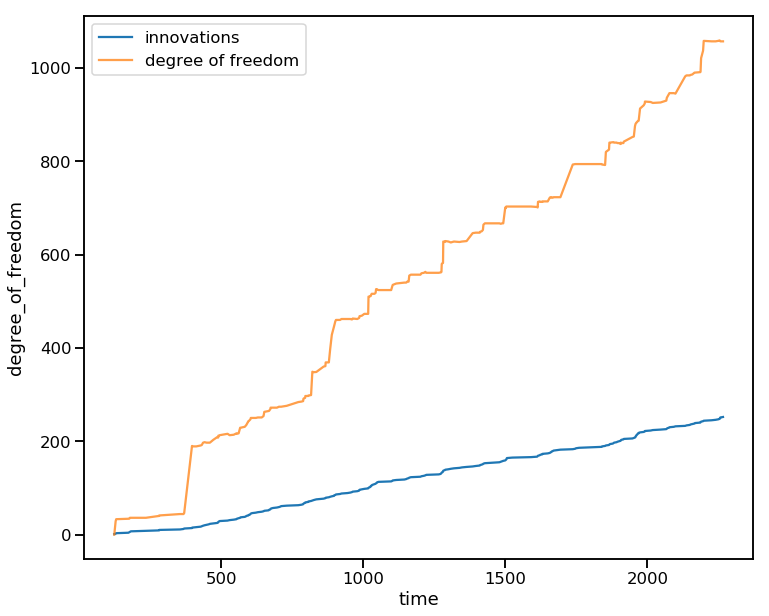

In [73]:
sns.set_context('talk')
fig, ax = plt.subplots(figsize = (12,10))
sns.lineplot(data = data_new.loc[data_new.family == myfam], x = 'time', y = 'num_obj', label = 'innovations')
# sns.lineplot(data = data_new, x = 'time', y = 'degree_of_freedom', hue = 'family')
sns.lineplot(data = data_new.loc[data_new.family == myfam], x = 'time', y = 'degree_of_freedom', alpha = 0.75, label = 'degree of freedom')
plt.savefig('innovation&df_growth', dpi = 100, transparent = True)
# plt.show()

What's the highest innovation_df for each family?

In [ ]:
test = data_new.groupby('family')['degree_of_freedom'].apply(max).to_frame().reset_index()

In [ ]:
test